In [2]:
from IPython import get_ipython
from IPython.display import display

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
#!pip install lxml
import os
from lxml import etree
import pandas as pd # Import pandas for creating the DataFrame
import matplotlib.pyplot as plt # Import matplotlib for plotting
import seaborn as sns # Import seaborn for enhanced plotting
import nltk # Import nltk for text processing
from tqdm import tqdm # Import tqdm for progress bar
from sklearn.model_selection import train_test_split # Import for splitting data
from tensorflow.keras.utils import to_categorical # Import for one-hot encoding labels
from tensorflow.keras.preprocessing.text import Tokenizer # Import for tokenization
from tensorflow.keras.preprocessing.sequence import pad_sequences # Import for padding sequences
from tensorflow.keras.models import Sequential # Import for sequential model
from tensorflow.keras.layers import LSTM, Dense, Bidirectional, Embedding, Dropout # Import layers

# Download necessary NLTK data
nltk.download('punkt')

def extract_report_data(xml_path):
    tree = etree.parse(xml_path)
    report_parts = []

    # 1. Extract specialty
    specialty_node = tree.xpath('//specialty')
    if specialty_node:
        if specialty_node[0].text:
            report_parts.append(specialty_node[0].text)

    # 2. Extract INDICATION AbstractText
    indication_node = tree.xpath('//AbstractText[@Label="INDICATION"]')
    if indication_node:
        if indication_node[0].text:
            report_parts.append(indication_node[0].text)

    # 3. Extract FINDINGS AbstractText
    findings_nodes = tree.xpath('//Abstract/AbstractText[@Label="FINDINGS"]')
    for node in findings_nodes:
        if node.text:
            report_parts.append(node.text)

    # 4. Extract IMPRESSION AbstractText
    impression_node = tree.xpath('//AbstractText[@Label="IMPRESSION"]')
    if impression_node:
        if impression_node[0].text:
            report_parts.append(impression_node[0].text)

    # 5. Extract MeSH major and automatic terms
    mesh_nodes = tree.xpath('//MeSH/major | //MeSH/automatic')
    for node in mesh_nodes:
        if node.text:
            report_parts.append(node.text)

    # 6. Extract caption
    caption_node = tree.xpath('//parentImage/caption')
    if caption_node:
        if caption_node[0].text:
            report_parts.append(caption_node[0].text)


    return ' '.join(report_parts)

# Directory containing XMLs
xml_dir = '/content/drive/MyDrive/medical_reports'

reports_data = []
for filename in os.listdir(xml_dir):
    if filename.endswith('.xml'):
        path = os.path.join(xml_dir, filename)
        report_text = extract_report_data(path)
        reports_data.append({"Sentence": report_text})

# Create a DataFrame
df = pd.DataFrame(reports_data)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [6]:
# %%
# Simple Sentiment labeling based on keywords (you might need a more robust method)
def assign_sentiment(text):
    text = text.lower()
    if 'normal' in text or 'no abnormality' in text or 'unremarkable' in text: # Add other positive indicators
        return 'positive'
    elif 'enlarged' in text or 'abnormal' in text or 'lesion' in text or 'failure' in text: # Add other negative indicators
        return 'negative'
    else:
        return 'neutral' # Or handle neutral cases as needed

df['Sentiment'] = df['Sentence'].apply(assign_sentiment)

# Display the first few rows of the DataFrame
print(df.head(14))

                                             Sentence Sentiment
0   pulmonary diseases XXXX-year-old woman, XXXX.....  positive
1   pulmonary diseases XXXX-year-old male post PIC...   neutral
2   pulmonary diseases XXXX-year-old female with X...  positive
3   pulmonary diseases XXXX-year-old female, preop...  positive
4   pulmonary diseases Hypoxia, aortic stenosis St...   neutral
5   pulmonary diseases History of pulmonary embolu...  positive
6   pulmonary diseases preop for XXXX surgery XXXX...  positive
7   pulmonary diseases Shortness of breath The car...  positive
8   pulmonary diseases Chest pain Stable cardiomed...  positive
9   pulmonary diseases History of atrial fibrillat...  positive
10  pulmonary diseases XXXX-year-old female, XXXX,...  positive
11  pulmonary diseases Previous XXXX,shortness of ...  positive
12  pulmonary diseases Chest pain The heart is aga...  negative
13  pulmonary diseases XXXX-year-old female, chest...  positive


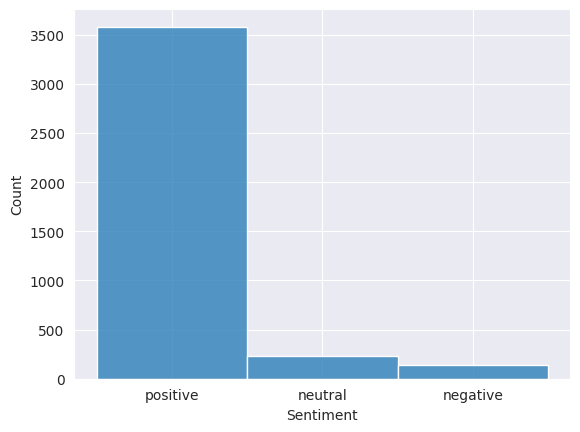

In [7]:
sns.set_style('darkgrid')
sns.histplot(x='Sentiment',data=df)
plt.show()

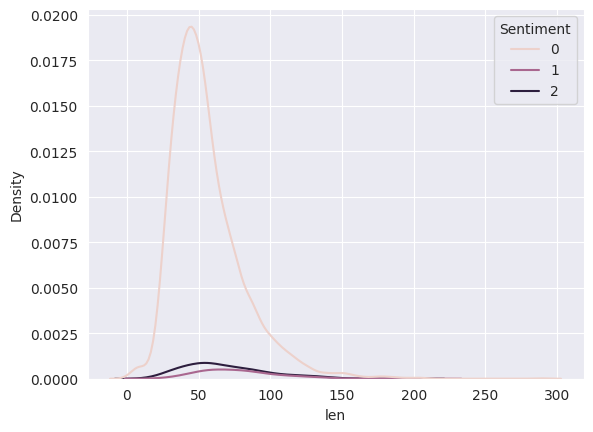

In [18]:
# Visualize sentence length distribution by sentiment
sns.kdeplot(x='len', hue='Sentiment', data=df)
plt.show()

In [23]:
# 0 -> Positive   1 -> Negative   2 -> Neutral
df['len'] = list(map(lambda x:len(str(x).split(' ')),df['Sentence']))
print(df.head())

                                            Sentence  Sentiment  len
0  pulmonary diseases XXXX-year-old woman, XXXX.....          0   66
1  pulmonary diseases XXXX-year-old male post PIC...          2   75
2  pulmonary diseases XXXX-year-old female with X...          0   37
3  pulmonary diseases XXXX-year-old female, preop...          0   68
4  pulmonary diseases Hypoxia, aortic stenosis St...          2   55


In [24]:
print(df['Sentiment'].corr(df['len']))

0.1596952992294002


In [29]:
import text_hammer as th
#!pip install text_hammer

sentences = df['Sentence'].copy()[:]
sentences = sentences.to_list()
sentences = list(map(lambda x: x.lower(),sentences))
sentences = list(map(lambda x: th.cont_exp(x),sentences))
sentences = list(map(lambda x: th.remove_html_tags(x),sentences))
sentences = list(map(lambda x: th.remove_stopwords(x),sentences))
sentences = list(map(lambda x: th.remove_special_chars(x),sentences))
sentences = list(map(lambda x: th.remove_accented_chars(x),sentences))
sentences = list(map(lambda x: th.make_base(x),sentences))

In [30]:
sentences[:5]

['pulmonary disease xxxxyearold woman xxxx lung clear bilaterally specifically evidence focal consolidation pneumothorax pleural effusion previously see right upper lobe mass lesion see xxxx study cardio mediastinal silhouette unremarkable visualize osseous structure thorax acute abnormality acute cardiopulmonary abnormality normal pa lateral chest xxxxx date xxxx xxxx xxxx midday',
 'pulmonary disease xxxxyearold male post picc placement 1 leave picc mid svc negative pneumothorax 2 unchanged bibasilar airspace opacity compatible pulmonary effusion atelectasis increase interstitial prominence reflect underlie pulmonary edema possibly secondary infectious etiology 3 stable postsurgical change distal right clavicle catheter indwellingleft opacitylungbasebilateral pleural effusionbasebilateral pulmonary atelectasisbasebilateral lunginterstitialprominent atelectase opacity pulmonary edema pulmonary effusion picc atelectasis clavicle pulmonary edema chest radiograph pa lateral xxxx',
 'pulm

In [35]:
# NLTK PUNKT is an unsupervised trainable tokenizer that splits text into sentences.
# Integrate word frequency analysis
#1) Unsupervised learning
#2) Abbreviation detection
#3) Collocation detection
#4) Sentence starter words

nltk.download('punkt_tab')

pairs = []
for sent in tqdm(sentences):
    pairs.extend(nltk.word_tokenize(sent))
freq = nltk.FreqDist(pairs)
freq.most_common(14)

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
100%|██████████| 3955/3955 [00:00<00:00, 5301.59it/s]


[('xxxx', 10586),
 ('pulmonary', 6624),
 ('disease', 6210),
 ('chest', 5529),
 ('normal', 5451),
 ('lung', 3616),
 ('lateral', 3473),
 ('effusion', 3454),
 ('pleural', 3434),
 ('acute', 3053),
 ('pa', 2806),
 ('pneumothorax', 2645),
 ('heart', 2615),
 ('size', 2272)]

<ipython-input-37-d5e52d2a9316>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='word', y='count', data=tempdf, palette=colors, dodge=False) # Use palette for different colors


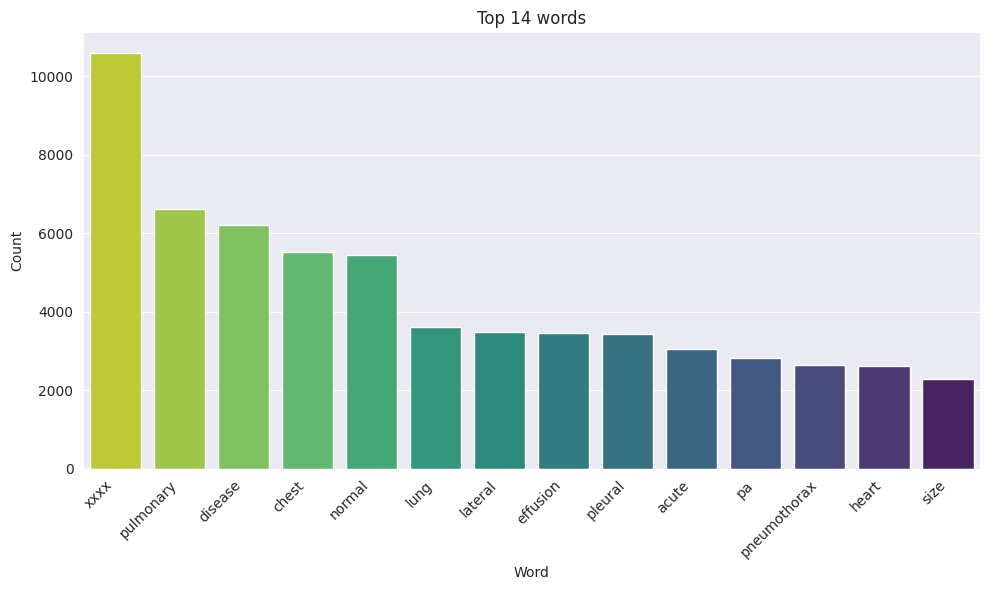

In [37]:
# Top 14 Words
tempdf = pd.DataFrame(freq.most_common(14),  columns=['word', 'count'])

# Create a color palette based on count
colors = sns.color_palette('viridis', len(tempdf))
colors = colors[::-1] # Reverse to have high count with one color, low count with another color

plt.figure(figsize=(10, 6)) # Increase figure size for better spacing
sns.barplot(x='word', y='count', data=tempdf, palette=colors, dodge=False) # Use palette for different colors

plt.title("Top 14 words")
plt.xlabel('Word') # Add x-axis label
plt.ylabel('Count') # Add y-axis label
plt.xticks(rotation=45, ha='right') # Rotate x-axis labels for better readability
plt.tight_layout() # Adjust layout to prevent labels overlapping
plt.show()

In [38]:
# Vectorization
# Prepare data for model training (using the new approach)
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np # Import numpy for array manipulation

# Determine the number of unique words for the tokenizer
num_words = 10000 # You can adjust this based on your vocabulary size

tokenizer = Tokenizer(num_words=num_words, oov_token="<OOV>")
tokenizer.fit_on_texts(sentences) # Use the 'sentences' list for fitting

y = to_categorical(df['Sentiment'])
x = sentences.copy() # Use the 'sentences' list for the text data
X_train,X_test, y_train,y_test = train_test_split(x,y,test_size=0.3,stratify=y,random_state=72)

X_train_ = tokenizer.texts_to_sequences(X_train)
# Determine maxlen based on your data or a reasonable value
maxlen = 81 # Using the value from your snippet
X_train_pad=pad_sequences(X_train_,maxlen=maxlen,padding='post')

X_test_ = tokenizer.texts_to_sequences(X_test)
X_test_pad = pad_sequences(X_test_, maxlen = maxlen, padding = 'post')

print(X_train_pad.shape,X_test_pad.shape)

(2768, 81) (1187, 81)


# **LSTM** (Long-Short-Time-Memory)

In [39]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense,Bidirectional,Embedding,Dropout

In [40]:
# LSTM General Model Architecture (Do Integreate)
lstm = Sequential()
lstm.add(Embedding(input_dim = num_words, # Use the determined num_words
                          output_dim = 100,
                          input_length= X_train_pad.shape[1])) # Use the padded sequence length
lstm.add(Dropout(0.2))
lstm.add(Bidirectional(LSTM(128,return_sequences=True)))
lstm.add(Dropout(0.2))
lstm.add(Bidirectional(LSTM(256,return_sequences=True)))
lstm.add(Dropout(0.2))
lstm.add(Bidirectional(LSTM(128,return_sequences=False)))
lstm.add(Dense(64,activation='tanh'))
lstm.add(Dense(32,activation='tanh'))
lstm.add(Dense(len(mapdf),activation='softmax')) # Output layer with number of sentiment classes and softmax activation

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [52]:
lstm.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 81, 100)        │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 81, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 81, 256)        │       234,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 81, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 81, 512)        │     1,050,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 81, 512)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 256)            │       656,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,880,395 (33.88 MB)

 Trainable params: 2,960,131 (11.29 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 5,920,264 (22.58 MB)

In [53]:
# Compile the model
lstm.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [54]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 5)
mc = ModelCheckpoint('./model.h5', monitor = 'val_accuracy', mode = 'max', verbose = 1, save_best_only = True)

In [55]:
# Train the model
# Adjust epochs and batch_size as needed
lstm_history = lstm.fit(X_train_pad,y_train, epochs = 10, batch_size = 64, validation_data=(X_test_pad, y_test),verbose = 1, callbacks= [es, mc])

Epoch 1/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.9492 - loss: 0.1637
Epoch 1: val_accuracy improved from -inf to 0.93260, saving model to ./model.h5


44/44 ━━━━━━━━━━━━━━━━━━━━ 9s 87ms/step - accuracy: 0.9492 - loss: 0.1635 - val_accuracy: 0.9326 - val_loss: 0.2480
Epoch 2/10
43/44 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.9546 - loss: 0.1404
Epoch 2: val_accuracy improved from 0.93260 to 0.94524, saving model to ./model.h5


44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - accuracy: 0.9547 - loss: 0.1397 - val_accuracy: 0.9452 - val_loss: 0.1662
Epoch 3/10
43/44 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.9613 - loss: 0.1154
Epoch 3: val_accuracy did not improve from 0.94524
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.9613 - loss: 0.1159 - val_accuracy: 0.9427 - val_loss: 0.1769
Epoch 4/10
43/44 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.9517 - loss: 0.1283
Epoch 4: val_accuracy improved from 0.94524 to 0.95535, saving model to ./model.h5


44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - accuracy: 0.9519 - loss: 0.1277 - val_accuracy: 0.9553 - val_loss: 0.0955
Epoch 5/10
43/44 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.9597 - loss: 0.0949
Epoch 5: val_accuracy did not improve from 0.95535
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.9597 - loss: 0.0953 - val_accuracy: 0.9553 - val_loss: 0.1357
Epoch 6/10
43/44 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9188 - loss: 0.2158
Epoch 6: val_accuracy did not improve from 0.95535
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 0.9171 - loss: 0.2200 - val_accuracy: 0.9056 - val_loss: 0.1633
Epoch 7/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.9308 - loss: 0.1564
Epoch 7: val_accuracy did not improve from 0.95535
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - accuracy: 0.9307 - loss: 0.1567 - val_accuracy: 0.9115 - val_loss: 0.1732
Epoch 8/10
43/44 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.9280 - loss: 0.1547
Epoch 8: val_accuracy did not improve from 

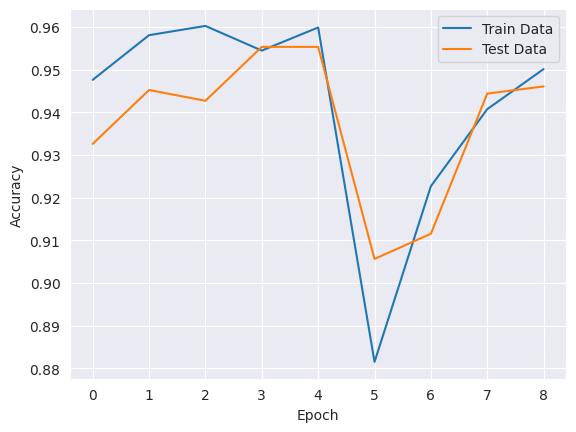

In [56]:
# Plot accuracy
plt.plot(lstm_history.history['accuracy'], label='Train Data')
plt.plot(lstm_history.history['val_accuracy'], label='Test Data')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.show()

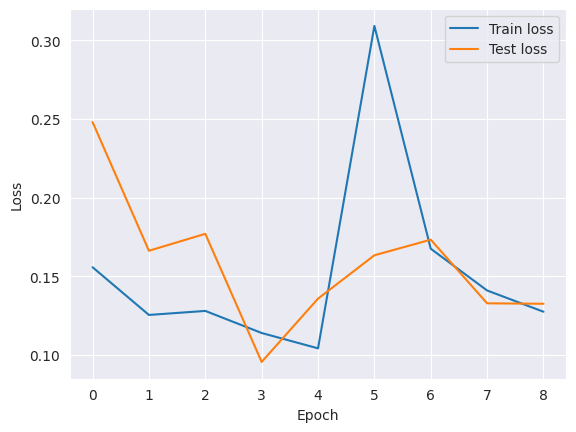

In [57]:
# Plot loss
plt.plot(lstm_history.history['loss'], label='Train loss')
plt.plot(lstm_history.history['val_loss'], label='Test loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='best')
plt.show()

In [65]:
# Generate classification report
from sklearn.metrics import classification_report, confusion_matrix

predictions = lstm.predict(X_test_pad)

true_labels_lstm = np.argmax(y_test, axis=1)
pred_labels_lstm = np.argmax(predictions, axis=1)

# Generate classification report

target_names=['positive','negative','neutral']
print(classification_report(true_labels_lstm, pred_labels_lstm, target_names=target_names))

38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
              precision    recall  f1-score   support

    positive       1.00      0.98      0.99      1075
    negative       0.00      0.00      0.00        41
     neutral       0.53      0.97      0.69        71

    accuracy                           0.95      1187
   macro avg       0.51      0.65      0.56      1187
weighted avg       0.93      0.95      0.94      1187



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


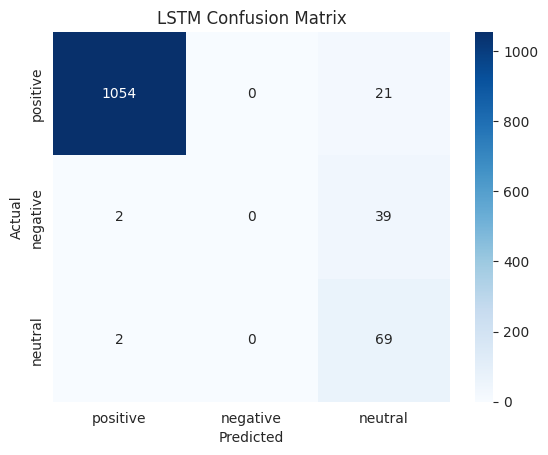

In [66]:
# Plot confusion matrix for LSTM
conf_mat_lstm = confusion_matrix(true_labels_lstm, pred_labels_lstm)
sns.heatmap(conf_mat_lstm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['positive', 'negative', 'neutral'],
            yticklabels=['positive', 'negative', 'neutral'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('LSTM Confusion Matrix')
plt.show()

# **BioBert Model** This model is for Medical and Clinical:

In [5]:
pip install keras-adamw

In [67]:
from IPython import get_ipython
from IPython.display import display
from google.colab import drive
drive.mount('/content/drive')

#!pip install transformers
#!pip install lxml
#!pip install keras-adamw

import os
from lxml import etree
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import torch
from transformers import BertTokenizer, BertForSequenceClassification
# Corrected import for AdamW
from torch.optim import AdamW
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import nltk

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [68]:
# Download necessary NLTK data
nltk.download('punkt')
nltk.download('punkt_tab') # Download tabular punkt for word tokenization

def extract_report_data(xml_path):
    tree = etree.parse(xml_path)
    report_parts = []

    # 1. Extract specialty
    specialty_node = tree.xpath('//specialty')
    if specialty_node:
        if specialty_node[0].text:
            report_parts.append(specialty_node[0].text)

    # 2. Extract INDICATION AbstractText
    indication_node = tree.xpath('//AbstractText[@Label="INDICATION"]')
    if indication_node:
        if indication_node[0].text:
            report_parts.append(indication_node[0].text)

    # 3. Extract FINDINGS AbstractText
    findings_nodes = tree.xpath('//Abstract/AbstractText[@Label="FINDINGS"]')
    for node in findings_nodes:
        if node.text:
            report_parts.append(node.text)

    # 4. Extract IMPRESSION AbstractText
    impression_node = tree.xpath('//AbstractText[@Label="IMPRESSION"]')
    if impression_node:
        if impression_node[0].text:
            report_parts.append(impression_node[0].text)

    # 5. Extract MeSH major and automatic terms
    mesh_nodes = tree.xpath('//MeSH/major | //MeSH/automatic')
    for node in mesh_nodes:
        if node.text:
            report_parts.append(node.text)

    # 6. Extract caption
    caption_node = tree.xpath('//parentImage/caption')
    if caption_node:
        if caption_node[0].text:
            report_parts.append(caption_node[0].text)

    return ' '.join(report_parts)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [69]:
# Directory containing XMLs
xml_dir = '/content/drive/MyDrive/medical_reports'

reports_data = []
for filename in os.listdir(xml_dir):
    if filename.endswith('.xml'):
        path = os.path.join(xml_dir, filename)
        report_text = extract_report_data(path)
        reports_data.append({"Sentence": report_text})

In [70]:
# Create a DataFrame
df = pd.DataFrame(reports_data)

In [83]:
# Simple Sentiment labeling based on keywords
def assign_sentiment(text):
    text = text.lower()
    if 'normal' in text or 'no abnormality' in text or 'unremarkable' in text:
        return 'positive'
    elif 'enlarged' in text or 'abnormal' in text or 'lesion' in text or 'failure' in text:
        return 'negative'
    else:
        return 'neutral'

df['Sentiment'] = df['Sentence'].apply(assign_sentiment)

# Display first 14 Dataframe.
print(df.head(14))

                                             Sentence Sentiment  len
0   pulmonary diseases XXXX-year-old woman, XXXX.....  positive   65
1   pulmonary diseases XXXX-year-old male post PIC...   neutral   75
2   pulmonary diseases XXXX-year-old female with X...  positive   36
3   pulmonary diseases XXXX-year-old female, preop...  positive   67
4   pulmonary diseases Hypoxia, aortic stenosis St...   neutral   55
5   pulmonary diseases History of pulmonary embolu...  positive   86
6   pulmonary diseases preop for XXXX surgery XXXX...  positive   40
7   pulmonary diseases Shortness of breath The car...  positive   63
8   pulmonary diseases Chest pain Stable cardiomed...  positive   54
9   pulmonary diseases History of atrial fibrillat...  positive   78
10  pulmonary diseases XXXX-year-old female, XXXX,...  positive   56
11  pulmonary diseases Previous XXXX,shortness of ...  positive   58
12  pulmonary diseases Chest pain The heart is aga...  negative   38
13  pulmonary diseases XXXX-year-o

In [87]:
# Word frequency analysis
sentences = df['Sentence'].tolist()
pairs = []
for sent in tqdm(sentences):
    pairs.extend(nltk.word_tokenize(sent))
freq = nltk.FreqDist(pairs)
print(freq.most_common(14))

100%|██████████| 3955/3955 [00:02<00:00, 1645.14it/s]


[('.', 27689), ('XXXX', 10606), (',', 7778), ('and', 6911), ('No', 6055), ('pulmonary', 5517), ('normal', 4969), ('is', 4917), ('are', 4682), ('of', 4579), ('the', 4044), ('diseases', 3978), ('The', 3744), ('pleural', 3058)]


In [90]:
# Initialize BioBERT tokenizer and model
model_name = 'dmis-lab/biobert-v1.1'
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=3)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dmis-lab/biobert-v1.1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [92]:
# Tokenize the sentences
input_ids = []
attention_masks = []

for sent in df['Sentence']:
    encoded_dict = tokenizer.encode_plus(
        sent,
        add_special_tokens=True,
        max_length=256,
        padding='max_length',
        return_attention_mask=True,
        return_tensors='pt',
        truncation=True
    )
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)

# Convert sentiment labels from strings to numerical values
sentiment_mapping = {'positive': 0, 'negative': 1, 'neutral': 2}
df['Sentiment'] = df['Sentiment'].map(sentiment_mapping)

# Create the labels tensor from the numerical sentiment values
labels = torch.tensor(df['Sentiment'].values)

In [93]:
# Split data into train and validation sets
train_idx, val_idx = train_test_split(
    np.arange(len(labels)),
    test_size=0.2,
    random_state=42,
    stratify=labels
)

train_dataset = TensorDataset(
    input_ids[train_idx],
    attention_masks[train_idx],
    labels[train_idx]
)

val_dataset = TensorDataset(
    input_ids[val_idx],
    attention_masks[val_idx],
    labels[val_idx]
)

batch_size = 16

train_dataloader = DataLoader(
    train_dataset,
    sampler=RandomSampler(train_dataset),
    batch_size=batch_size
)

validation_dataloader = DataLoader(
    val_dataset,
    sampler=SequentialSampler(val_dataset),
    batch_size=batch_size
)

In [94]:
# Set up optimizer and training parameters
optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)
epochs = 3

In [95]:
print(torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU")

Tesla T4


In [96]:
# Training loop
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

for epoch in range(epochs):
    model.train()
    total_train_loss = 0

    for batch in tqdm(train_dataloader):
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        model.zero_grad()

        outputs = model(
            b_input_ids,
            token_type_ids=None,
            attention_mask=b_input_mask,
            labels=b_labels
        )

        loss = outputs[0]
        total_train_loss += loss.item()

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

    avg_train_loss = total_train_loss / len(train_dataloader)
    print(f'Epoch {epoch+1}, Average Training Loss: {avg_train_loss:.2f}')

100%|██████████| 198/198 [02:09<00:00,  1.53it/s]


Epoch 1, Average Training Loss: 0.19


100%|██████████| 198/198 [02:15<00:00,  1.46it/s]


Epoch 2, Average Training Loss: 0.02


100%|██████████| 198/198 [02:16<00:00,  1.45it/s]

Epoch 3, Average Training Loss: 0.02


In [102]:
# Evaluation
model.eval()
predictions, true_labels = [], []

for batch in validation_dataloader:
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch

    with torch.no_grad():
        outputs = model(
            b_input_ids,
            token_type_ids=None,
            attention_mask=b_input_mask
        )

    logits = outputs[0]
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    predictions.append(logits)
    true_labels.append(label_ids)

In [103]:
# Combine results
predictions = np.concatenate(predictions, axis=0)
true_labels = np.concatenate(true_labels, axis=0)
pred_labels = np.argmax(predictions, axis=1)

In [104]:
# Print classification report
print("\nClassification Report:")
print(classification_report(true_labels, pred_labels, target_names=['positive', 'negative', 'neutral']))


Classification Report:
              precision    recall  f1-score   support

    positive       1.00      1.00      1.00       717
    negative       0.93      0.96      0.95        27
     neutral       0.98      1.00      0.99        47

    accuracy                           1.00       791
   macro avg       0.97      0.99      0.98       791
weighted avg       1.00      1.00      1.00       791



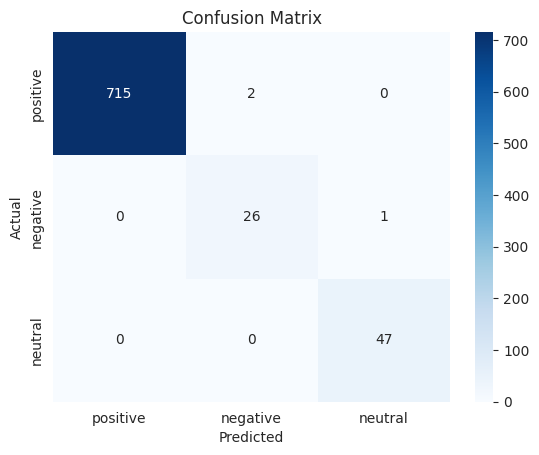

In [105]:
# Confusion matrix
conf_mat = confusion_matrix(true_labels, pred_labels)
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues',
            xticklabels=['positive', 'negative', 'neutral'],
            yticklabels=['positive', 'negative', 'neutral'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

In [106]:
# Save the model
output_dir = '/content/drive/MyDrive/biobert_sentiment_model'
model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)
print("Model saved to", output_dir)

Model saved to /content/drive/MyDrive/biobert_sentiment_model


In [107]:
# Training loop (Modified to capture history)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

biobert_train_loss_history = []
biobert_val_loss_history = []
biobert_val_accuracy_history = []

for epoch in range(epochs):
    model.train()
    total_train_loss = 0

    for step, batch in enumerate(tqdm(train_dataloader)):
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        model.zero_grad()

        outputs = model(
            b_input_ids,
            token_type_ids=None,
            attention_mask=b_input_mask,
            labels=b_labels
        )

        loss = outputs[0]
        total_train_loss += loss.item()

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

    avg_train_loss = total_train_loss / len(train_dataloader)
    biobert_train_loss_history.append(avg_train_loss)
    print(f'Epoch {epoch+1}, Average Training Loss: {avg_train_loss:.2f}')

    # Evaluate after each epoch to get validation history
    model.eval()
    total_eval_loss = 0
    correct_predictions = 0
    total_predictions = 0

    for batch in validation_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        with torch.no_grad():
            outputs = model(
                b_input_ids,
                token_type_ids=None,
                attention_mask=b_input_mask,
                labels=b_labels
            )

        loss = outputs[0]
        logits = outputs[1]

        total_eval_loss += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        pred_flat = np.argmax(logits, axis=1).flatten()
        labels_flat = label_ids.flatten()

        correct_predictions += np.sum(pred_flat == labels_flat)
        total_predictions += len(labels_flat)

    avg_val_loss = total_eval_loss / len(validation_dataloader)
    val_accuracy = correct_predictions / total_predictions

    biobert_val_loss_history.append(avg_val_loss)
    biobert_val_accuracy_history.append(val_accuracy)

    print(f"  Validation Loss: {avg_val_loss:.2f}")
    print(f"  Validation Accuracy: {val_accuracy:.2f}")

100%|██████████| 198/198 [02:09<00:00,  1.53it/s]


Epoch 1, Average Training Loss: 0.01
  Validation Loss: 0.02
  Validation Accuracy: 1.00


100%|██████████| 198/198 [02:15<00:00,  1.46it/s]


Epoch 2, Average Training Loss: 0.01
  Validation Loss: 0.02
  Validation Accuracy: 1.00


100%|██████████| 198/198 [02:16<00:00,  1.45it/s]


Epoch 3, Average Training Loss: 0.00
  Validation Loss: 0.02
  Validation Accuracy: 1.00


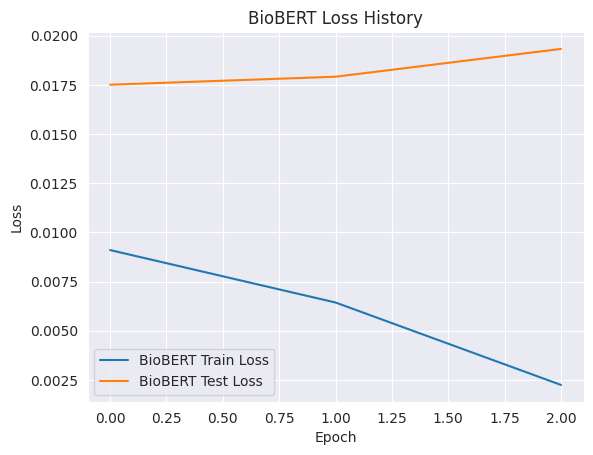

In [108]:
# Plot accuracy
plt.plot(biobert_train_loss_history, label='BioBERT Train Loss')
plt.plot(biobert_val_loss_history, label='BioBERT Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='best')
plt.title('BioBERT Loss History')
plt.show()

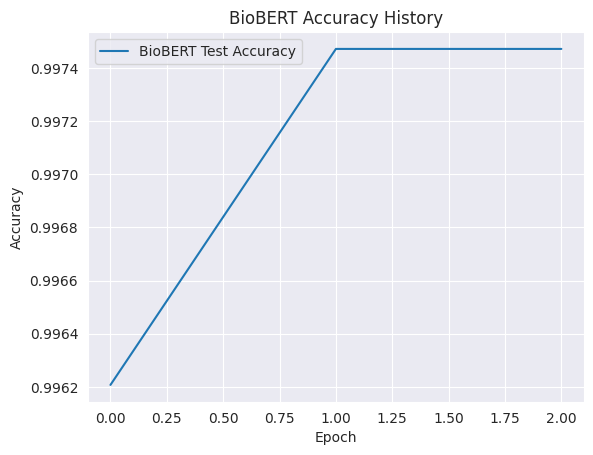

In [109]:
# Plot loss
plt.plot(biobert_val_accuracy_history, label='BioBERT Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.title('BioBERT Accuracy History')
plt.show()

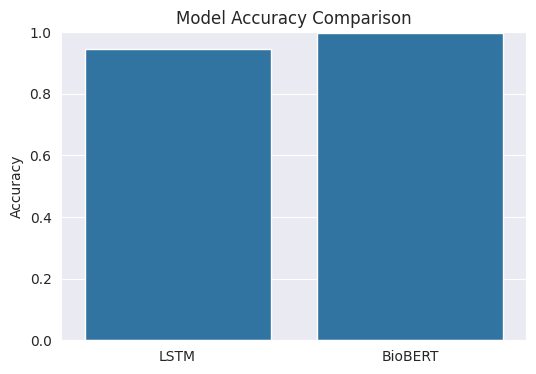

In [110]:
# --- Comparison Plot ---
# Ensure you have the lstm_history object from your previous LSTM training

lstm_accuracy = lstm_history.history['val_accuracy'][-1] # Get the last epoch's validation accuracy
biobert_accuracy = biobert_val_accuracy_history[-1] # Get the last epoch's validation accuracy from BioBERT

models = ['LSTM', 'BioBERT']
accuracies = [lstm_accuracy, biobert_accuracy]

plt.figure(figsize=(6, 4))
sns.barplot(x=models, y=accuracies)
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')
plt.ylim(0, 1) # Set 0 to 1 for accuracy, it's mean the start is 0.0 unitl 1.0
plt.show()

# Last Result and Compersion – Between 2 Two Models -> LSTM & BioBERT

Based on the projcet code provided, here's a comparison between the LSTM and BioBERT models for the medical report sentiment classification task:

**Model Architecture:**
*   **LSTM:** The code implements a sequential LSTM model with multiple bidirectional LSTM layers and dense layers. It uses an embedding layer to represent words. This architecture is designed to capture sequential dependencies in the text.

*   **BioBERT:** The code utilizes a pre-trained BioBERT model (specifically 'dmis-lab/biobert-v1.1') which is a transformer-based model. This architecture leverages attention mechanisms to capture relationships between words regardless of their position in the sequence, and it's specifically trained on biomedical text.





### Performance:

* **LSTM:** The code provides plots for training and validation accuracy and loss, as well as a classification report and confusion matrix for the LSTM model. To assess its performance, you would examine these plots and the metrics from the classification report (precision, recall, F1-score) and confusion matrix.

* **BioBERT:** Similar to the LSTM, the code provides history for validation loss and accuracy, and it generates a classification report and confusion matrix for the BioBERT model. You would evaluate its performance using these outputs.

**Data Requirements:**

* **LSTM:** Requires a labeled dataset for training. While it can learn representations from scratch with the embedding layer, the performance heavily depends on the size and quality of the training data.

* **BioBERT:** Benefits significantly from pre-training on a massive corpus of biomedical text. This pre-training allows it to learn rich representations of biomedical terms and concepts, requiring less labeled data for fine-tuning on a specific task like sentiment classification compared to a standard LSTM.


**Computational Resources:**
•	LSTM: Generally less computationally intensive to train compared to transformer-based models like BioBERT. The training time and memory requirements are lower.

•	BioBERT: More computationally demanding due to its larger size and the complexity of the transformer architecture. Training or fine-tuning BioBERT typically requires a GPU with more memory and processing power.


**Interpretability:**
•	LSTM: Can be somewhat more interpretable than transformer models, as it processes text sequentially. You can potentially examine the hidden states to understand what the model is focusing on at different points in the sequence.

•	BioBERT: Due to its complex, non-sequential architecture and attention mechanisms, understanding exactly why it makes a specific prediction is more challenging.


**Most Significant Difference:**

The most significant difference lies in their architecture and how they leverage pre-training. LSTM is a sequential model that learns from the provided training data, while BioBERT is a pre-trained transformer model that has already learned a vast amount of information about the biomedical domain. This pre-training gives BioBERT a significant advantage in understanding the nuances of medical text.


**Conclusion:**

Based on the nature of medical reports and clinical text, BioBERT is likely the better model for this task. Here's why:

* **Domain Expertise:** BioBERT's pre-training on biomedical text allows it to better understand the specific language, terminology, and context found in medical reports. This is a crucial advantage for accurate sentiment analysis in this domain.

* **Handling Complex Relationships:** Transformer models like BioBERT excel at capturing complex, non-sequential relationships between words, which are often present in medical text (e.g., linking findings to impressions).

* **Potential for Higher Accuracy:** While you need to compare the actual performance metrics from the code's output, BioBERT, being a more advanced and domain-specific model, is expected to achieve higher accuracy on this task, especially with a limited amount of labeled data.


Although LSTM is simpler and less computationally expensive, it lacks the inherent domain knowledge of BioBERT. For a task like sentiment analysis of medical reports, leveraging the pre-trained knowledge of BioBERT is a more effective approach.
To definitively determine which model is best for your specific data, you should compare the metrics from the classification reports and confusion matrices generated by both models in your Colab notebook. Look at precision, recall, F1-score, and overall accuracy. However, based on the architecture and pre-training, BioBERT has a strong theoretical advantage for this domain.
